<a href="https://colab.research.google.com/github/analiacuracaram/UGR_DeepLearning/blob/main/Trabajo_Practico_N1_Aprendizaje_Profundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Alumnas**
      Guadalupe Solé

      Analía Cura Caram

##Readme
Este trabajo se abordó siguiendo la documentación citada en https://www.physionet.org/content/mitdb/1.0.0/

Acorde a como allí se solicita, se cita la fuente de información:

*Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.*

#Paso 1 - Dataset

Documentación wfdb https://physionet.org/content/wfdb-python/3.4.1/

In [36]:
!pip install wfdb #Instalamos el paquete wfdb para poder manejar los waveform

##1.1 Importamos el dataset

In [37]:
import wfdb
waveform_db = 'mitdb'

In [38]:
subjects = wfdb.get_record_list(waveform_db)
print(f"La '{waveform_db}' base de datos contiene {len(subjects)} muestras")
print(f"Ejemplos de registros: {subjects[:5]}")

La 'mitdb' base de datos contiene 48 muestras
Ejemplos de registros: ['100', '101', '102', '103', '104']


###Exploración del dataset

In [39]:
record = wfdb.rdrecord('100', pn_dir='mitdb') ## Carga el registro 100 desde la base MITDB
record

In [40]:
print("Frecuencia de muestreo:", record.fs)  # frecuencia de muestreo
print("Nombres de los canales:", record.sig_name)  # nombres de los canales
print("Dimensión de la señal:", record.p_signal.shape)  # dimensión de la señal

Frecuencia de muestreo: 360
Nombres de los canales: ['MLII', 'V5']
Dimensión de la señal: (650000, 2)


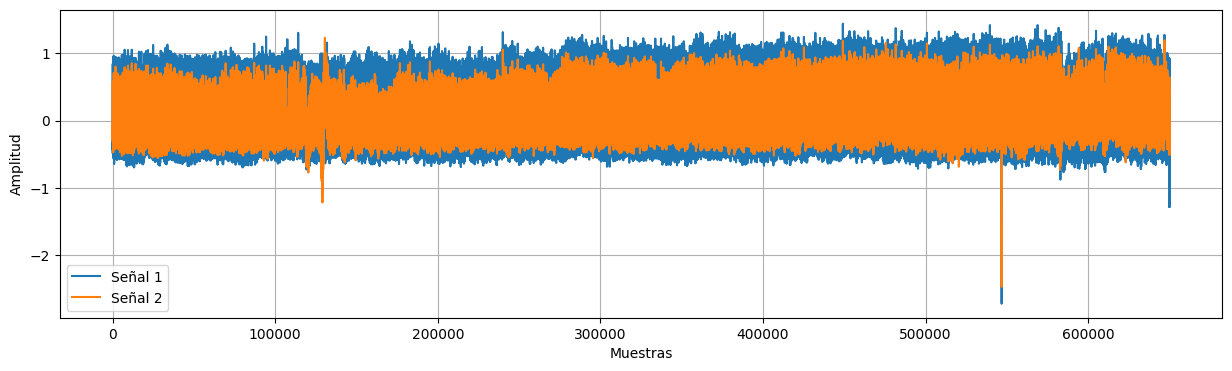

In [41]:
#Graficamos el registro 100
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
for i in range(record.p_signal.shape[1]):
    plt.plot(record.p_signal[:, i], label=f'Señal {i+1}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


#Paso 2 - Preprocesamiento

1. Nos enfocamos solo en 3 clases: 'N' → Latido normal (Normal beat). 'V' → Contracción ventricular prematura (PVC),'A' → Latido supraventricular prematuro (APB), descartando otros tipos de latidos
2. Recorremos cada registro de la base MIT-BIH; se filtra toda la señal usando un filtro Butterworth pasa-bajos de 40 Hz para reducir el ruido.  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
3. Segmentación: Se corta una ventana de 200 milisegundos (72 muestras) alrededor del pico. Se extrae solo la señal que rodea al evento cardíaco.
4. Normalización: Cada ventana segmentada se normaliza: Media = 0, Desviación estándar = 1; de esta forma quedan los latidos comparables entre si.
Cada latido filtrado, segmentado y normalizado se guarda en un DataFrame (df)



##2.1/2.2 Filtrado y Segmentación

In [ ]:
## 1. Instalamos e importamos librerías
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import pandas as pd


In [ ]:
# 2. Definimos parámetros
#waveform_db = 'mitdb'
clases_interes = ['N', 'V', 'A']  # Nos quedamos solo con las clases de interés
fs = 360  # Definimos la frecuencia de muestreo (Hz)
ventana_muestras = int(0.2 * fs)  # 0.2 segundos alrededor del pico R. * 360 Hz frecuencia = 72 muestras
mitad_ventana = ventana_muestras // 2

In [ ]:
# 3. Definimos funciones
def butter_lowpass_filter(data, cutoff=40, fs=360, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def normalizar_latido(latido):
    return (latido - np.mean(latido)) / np.std(latido)

# 4. Obtenemos lista de registros
lista_registros = wfdb.get_record_list(waveform_db)
print(f"La base de datos '{waveform_db}' contiene {len(lista_registros)} registros.")

# 5. Inicializamos lista para guardar latidos
data = []

# 6. Recorremos registros
for registro in lista_registros:
    print(f"Procesando registro: {registro}...")

    # Carga la señal y anotaciones
    record = wfdb.rdrecord(registro, pn_dir='mitdb')
    annotation = wfdb.rdann(registro, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]  #Canal principal

    # Filtramos la señal completa una sola vez
    signal_filtrada = butter_lowpass_filter(signal, cutoff=40, fs=360)

    # Recorremos latidos anotados
    for index, label in zip(annotation.sample, annotation.symbol):
        if label in clases_interes:
            inicio = index - mitad_ventana
            fin = index + mitad_ventana
            if inicio >= 0 and fin <= len(signal_filtrada):
                # Segmentamos ventana de 200ms
                latido = signal_filtrada[inicio:fin]

                # Normalizamos el latido
                latido_normalizado = normalizar_latido(latido)

                # Guarda el  latido
                data.append({
                    'record': registro,
                    'sample': index,
                    'label': label,
                    'signal_normalizada': latido_normalizado
                })

# 7. Creamos el DataFrame
df = pd.DataFrame(data)

print(f"\n Procesamiento completo: {len(df)} latidos segmentados, filtrados y normalizados.")
df.head()


In [ ]:
df.shape

In [ ]:
df['label'].value_counts()

In [ ]:
df['label'].value_counts(normalize=True).plot(kind='bar', color='salmon')
plt.title('Distribución de clases (proporcional)')
plt.ylabel('Proporción')
plt.xlabel('Clase')
plt.grid(axis='y')
plt.show()

El dataset tiene un desbalance severo, la clase mayoritaria (N) representa casi el 90%, esto puede:

Sesgar el entrenamiento del modelo.

Generar alta accuracy pero con malas métricas para clases minoritarias.

Causar que el modelo “ignore” las clases menos frecuentes.

##2.3 División de datos
•	70% entrenamiento, 15% validación, 15% test (mezcla aleatoria).


In [ ]:
# 1. preparamos X e y
X = np.vstack(df['signal_normalizada'].values)  # Señales
y = df['label'].values                          # Etiquetas

# 2. dividimos en entrenamiento, validación y test
from sklearn.model_selection import train_test_split

# Primera división: entrenamiento (70%) y "restante" (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Segunda división: validación (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Mostramos tamaños
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de test: {X_test.shape[0]}")


In [ ]:
pd.Series(y_train).value_counts()

In [ ]:
pd.Series(y).value_counts()


#Paso 3 - Modelado

##3.1 Red Prealimentada (MLP)

###Definición de la arquitectura

In [ ]:
#Convertimos las etiquetas a enteros para que puedan ser compiladas por sparse_categorical_crossentropy
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [ ]:
#1. Importamos las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Red neuronal **Perceptron Multicapa (MLP)** densa (fully connected) con dos capas ocultas y una de salida.

Arquitectura:

**Capa Dense** (64 neuronas, activación ReLU)
Esta primera capa procesa directamente el vector de entrada (el latido completo, ya segmentado y normalizado). Tiene 64 neuronas que aprenden representaciones abstractas del latido.

**Dropout** (tasa 0.3)
Se aplica para prevenir el sobreajuste desactivando aleatoriamente el 30% de las neuronas durante el entrenamiento.

**Capa Dense** (32 neuronas, activación ReLU)
Segunda capa densa, con menos neuronas, que permite capturar combinaciones más refinadas de las características detectadas por la capa anterior.

**Dropout** (tasa 0.3)
Refuerza la regularización antes de la salida.

**Capa Dense** (3 neuronas, activación softmax)
Capa de salida, con una neurona por clase (N, V, A), usando softmax para obtener la probabilidad de pertenencia a cada clase.



In [ ]:
# 2. Definimos la arquitectura de 2 capas densas
def crear_modelo():
  model = Sequential([
      Dense(64, activation='relu', input_shape=(ventana_muestras,)),
      #Añadimos regulación dropout "apagando" el 30% de las neuronas de la capa anterior (valor intermedio entre 0.2 y 0.5 que son los valores habituales)
      #De esta forma evitamos un posible overfitting en arquitecturas con capas densas
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(3, activation='softmax')  # Probabilidad para las 3 clases: N, V, A
  ])
  return model

###Entrenamiento

1. Compararemos 2 métodos optimizadores, Adam y SDG

https://keras.io/api/optimizers/adam/

https://keras.io/api/optimizers/sgd/


In [ ]:
import time

model_adam = crear_modelo()
model_adam.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #Utilizamos la función de pérdida que indica la consigna

start_adam = time.time() #Vamos a medir el tiempo de ejecución
history_adam = model_adam.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, #Utilizamos el máximo que indica la consigna
    batch_size=32,
    verbose=0
)
end_adam = time.time()
tiempo_adam = end_adam - start_adam

In [ ]:
from tensorflow.keras.optimizers import SGD

model_sgd = crear_modelo()
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(optimizer=optimizer_sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_sdg = time.time()
history_sgd = model_sgd.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)
end_sdg = time.time()
tiempo_sdg = end_sdg - start_sdg

## 3.2 Red Convolucional (CNN)

El modelo **model_cnn** es una red neuronal convolucional unidimensional (Conv1D).

**Capa Conv1D** (32 filtros, tamaño de ventana 5, activación ReLU): Esta capa realiza la convolución unidimensional sobre los datos de entrada. Los 32 filtros indican que se extraerán 32 características diferentes de la secuencia de entrada. La activación ReLU (Rectified Linear Unit) se utiliza para introducir no linealidad en la salida de esta capa.

**Capa MaxPooling1D** (tamaño 2): Después de cada capa Conv1D, se aplica una capa de MaxPooling1D para reducir la longitud de la secuencia. En este caso, el tamaño 2 indica que se reducirá la longitud de la secuencia a la mitad.

**Capa Conv1D** (64 filtros, tamaño de ventana 5, activación ReLU): Esta es otra capa Conv1D que sigue a la primera capa de MaxPooling1D. Tiene 64 filtros para extraer características más complejas de las características ya extraídas por la capa anterior.

**Capa MaxPooling1D** (tamaño 2): Similar a la primera capa de MaxPooling1D, esta capa reduce la longitud de la secuencia a la mitad nuevamente después de la segunda capa Conv1D.

**Capa Flatten**: Esta capa se utiliza para aplanar los datos 3D (en este caso, los datos de salida de las capas de MaxPooling1D) en un vector 1D. Esto es necesario antes de pasar los datos a las capas densamente conectadas (Dense).

**Capa Dense** (64 neuronas, activación ReLU): Una capa densamente conectada con 64 neuronas y activación ReLU. Esta capa procesa las características extraídas y aprendidas por las capas convolucionales y de pooling.

**Capa Dense** (3 neuronas, activación softmax): Capa de salida con 3 neuronas, una para cada clase (N, V, A). La activación softmax se utiliza aquí para calcular la probabilidad de que cada muestra pertenezca a cada una de las clases.

In [ ]:
import wfdb
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

###Definición de la arquitectura

In [ ]:
def crear_modelo_cnn():
  model_cnn = Sequential([
      Conv1D(32, 5, activation='relu', input_shape=(ventana_muestras, 1)),  # Primera capa Conv1D
      MaxPooling1D(2),  # Capa de MaxPooling1D para reducir la longitud de la secuencia
      Conv1D(64, 5, activation='relu'),  # Segunda capa Conv1D
      MaxPooling1D(2),  # Otra capa de MaxPooling1D para reducir la longitud
      Flatten(),  # Aplanar los datos para la capa densa
      Dense(64, activation='relu'),  # Capa Dense con activación ReLU
      Dense(3, activation='softmax')  # Capa de salida para 3 clases: N, V, A con activación softmax
  ])
  return model_cnn

###Entrenamiento

In [ ]:
# Optimizador ADAMS
# Compilar el modelo
model_adam_cnn = crear_modelo_cnn()

model_adam_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_adam_cnn = time.time() #Vamos a medir el tiempo de ejecución
history_adam_cnn = model_adam_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, #Utilizamos el máximo que indica la consigna
    batch_size=128,
    verbose=0
)
end_adam_cnn = time.time()
tiempo_adam_cnn = end_adam_cnn - start_adam_cnn


In [26]:
#Optimizador RMSPROP
from tensorflow.keras.optimizers import RMSprop

# Compilar el modelo con RMSprop
model_rms_cnn = crear_modelo_cnn()
model_rms_cnn.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Medir tiempo de entrenamiento
start_rmsprop_cnn = time.time()

history_rms_cnn = model_rms_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=0
)

end_rmsprop_cnn = time.time()
tiempo_rmsprop = end_rmsprop_cnn - start_rmsprop_cnn

Se probó el modelo modificando el hiperparámetro batch_size y se encontró una optimización en el tiempo de ejecución con batch_size = 128

#Paso 4 - Evaluación

##4.1 - Evaluación Red Prealimentada (MLP)

In [27]:
#Precisión general
loss, acc = model_adam.evaluate(X_test, y_test)
print(f"Accuracy general Adam: {acc:.2%}")
print(f"Tiempo de entrenamiento con Adam: {tiempo_adam:.2f} segundos")

loss, acc = model_sgd.evaluate(X_test, y_test)
print(f"Accuracy general SDG: {acc:.2%}")
print(f"Tiempo de entrenamiento con Adam: {tiempo_sdg:.2f} segundos")

398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9819 - loss: 0.0639
Accuracy general Adam: 98.10%
Tiempo de entrenamiento con Adam: 407.82 segundos
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9780 - loss: 0.0777
Accuracy general SDG: 97.69%
Tiempo de entrenamiento con Adam: 362.94 segundos


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


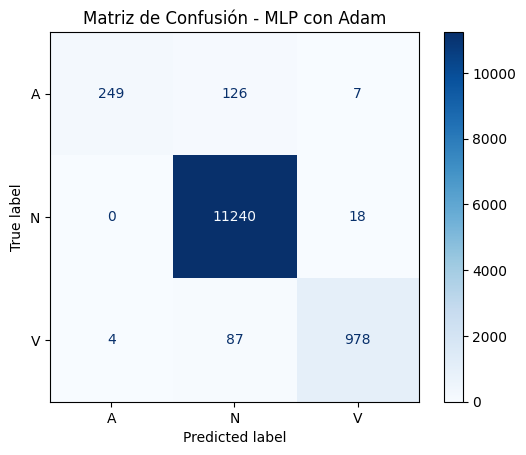

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.65      0.78       382
           1       0.98      1.00      0.99     11258
           2       0.98      0.91      0.94      1069

    accuracy                           0.98     12709
   macro avg       0.98      0.86      0.91     12709
weighted avg       0.98      0.98      0.98     12709



In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_adam.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - MLP con Adam")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


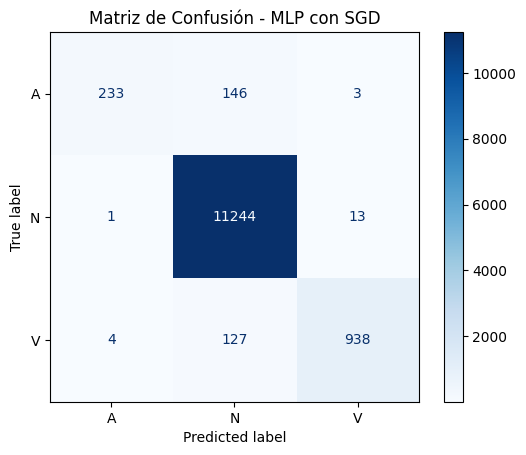

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.61      0.75       382
           1       0.98      1.00      0.99     11258
           2       0.98      0.88      0.93      1069

    accuracy                           0.98     12709
   macro avg       0.98      0.83      0.89     12709
weighted avg       0.98      0.98      0.98     12709



In [29]:
# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_sgd.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - MLP con SGD")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


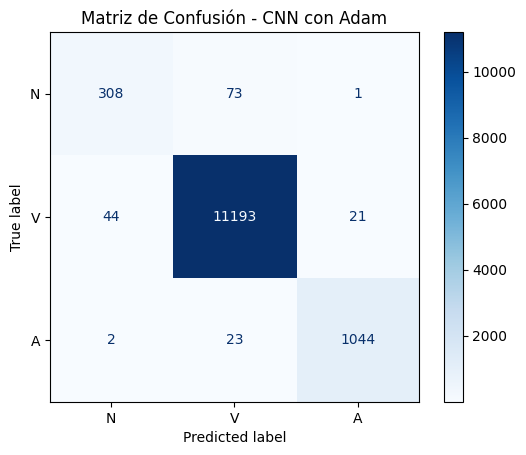

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_adam_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['N', 'V', 'A'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - CNN con Adam")
plt.show()


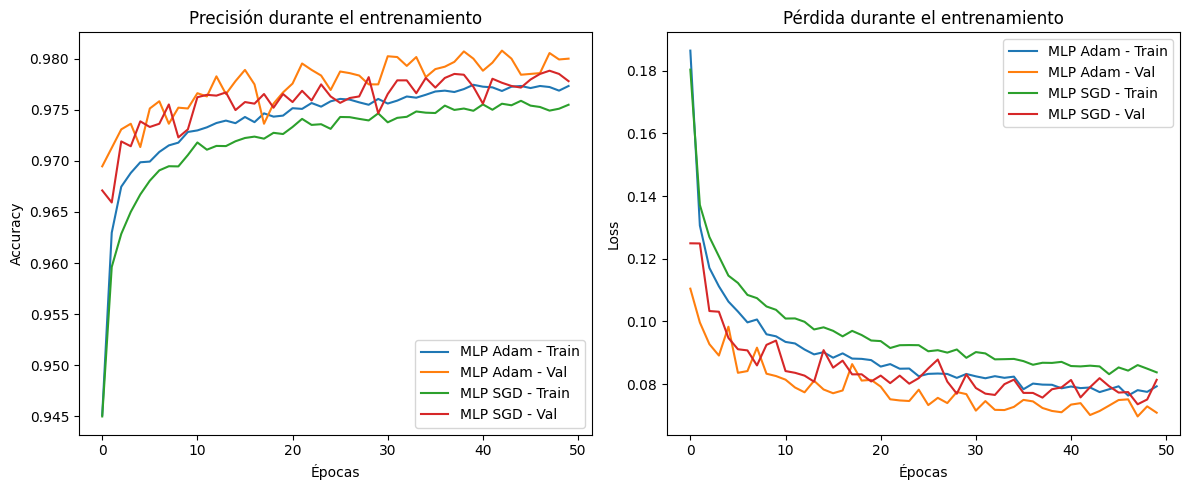

In [31]:
#Graficamos la comparación entre ambos optimizadores (ADAM - SDG)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='MLP Adam - Train')
plt.plot(history_adam.history['val_accuracy'], label='MLP Adam - Val')
plt.plot(history_sgd.history['accuracy'], label='MLP SGD - Train')
plt.plot(history_sgd.history['val_accuracy'], label='MLP SGD - Val')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='MLP Adam - Train')
plt.plot(history_adam.history['val_loss'], label='MLP Adam - Val')
plt.plot(history_sgd.history['loss'], label='MLP SGD - Train')
plt.plot(history_sgd.history['val_loss'], label='MLP SGD - Val')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##4.2 - Evaluación red Convolucional (CNN)

Se entrenó el modelo variando el valor del hiperparámetro batch_size, utilizando los valores 64, 128 y 256 para analizar su impacto en el rendimiento.

Resultados:

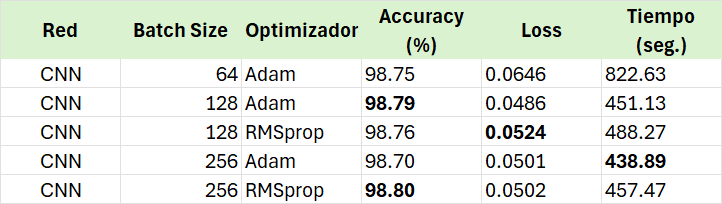

El optimizador RMSprop, con un batch size de 256, alcanzó la mayor precisión registrada, con un valor de 98.80 %.

No obstante, si se busca reducir el tiempo de entrenamiento sin comprometer significativamente el rendimiento, la configuración con **Adam y batch size de 128** representa el mejor equilibrio entre eficiencia y precisión.



In [32]:
loss, acc = model_adam_cnn.evaluate(X_test, y_test)
print(f"Accuracy general Adam para CNN: {acc:.2%}")
print(f"Tiempo de entrenamiento con Adam para CNN: {tiempo_adam_cnn:.2f} segundos")

loss, acc = model_rms_cnn.evaluate(X_test, y_test)
print(f"Accuracy general RMSprp para CNN: {acc:.2%}")
print(f"Tiempo de entrenamiento con RMSprop para CNN: {tiempo_rmsprop:.2f} segundos")


398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9883 - loss: 0.0471
Accuracy general Adam para CNN: 98.71%
Tiempo de entrenamiento con Adam para CNN: 494.49 segundos
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9862 - loss: 0.0527
Accuracy general RMSprp para CNN: 98.65%
Tiempo de entrenamiento con RMSprop para CNN: 486.47 segundos


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


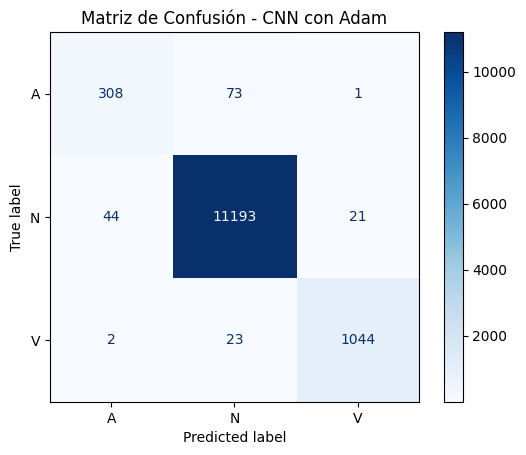

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       382
           1       0.99      0.99      0.99     11258
           2       0.98      0.98      0.98      1069

    accuracy                           0.99     12709
   macro avg       0.95      0.93      0.94     12709
weighted avg       0.99      0.99      0.99     12709



In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_adam_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - CNN con Adam")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


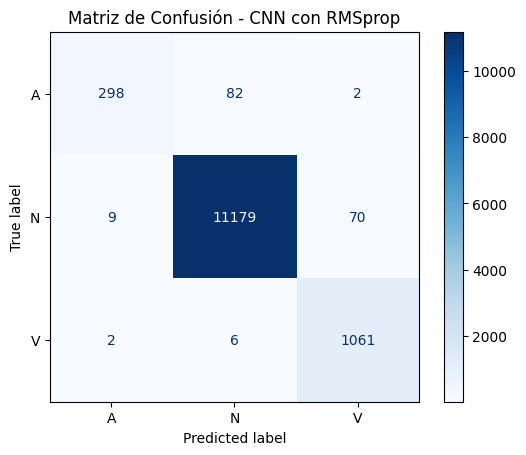

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86       382
           1       0.99      0.99      0.99     11258
           2       0.94      0.99      0.96      1069

    accuracy                           0.99     12709
   macro avg       0.96      0.92      0.94     12709
weighted avg       0.99      0.99      0.99     12709



In [34]:
# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_rms_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - CNN con RMSprop")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

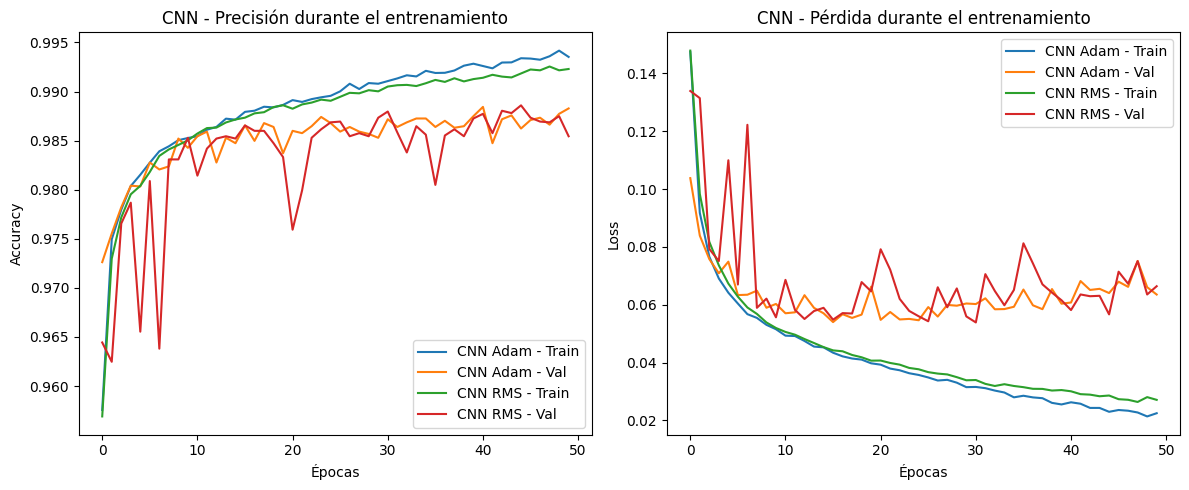

In [35]:
#Graficamos la comparación entre ambos optimizadores con Batch Size = 128
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_adam_cnn.history['accuracy'], label='CNN Adam - Train')
plt.plot(history_adam_cnn.history['val_accuracy'], label='CNN Adam - Val')
plt.plot(history_rms_cnn.history['accuracy'], label='CNN RMS - Train')
plt.plot(history_rms_cnn.history['val_accuracy'], label='CNN RMS - Val')
plt.title('CNN - Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_adam_cnn.history['loss'], label='CNN Adam - Train')
plt.plot(history_adam_cnn.history['val_loss'], label='CNN Adam - Val')
plt.plot(history_rms_cnn.history['loss'], label='CNN RMS - Train')
plt.plot(history_rms_cnn.history['val_loss'], label='CNN RMS - Val')
plt.title('CNN - Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Aunque ambos optimizadores alcanzan buenos resultados, Adam demuestra ser la opción más eficiente y precisa para esta arquitectura CNN aplicada a la clasificación de pulsos. Presenta menor pérdida, ligeramente mayor precisión, y un menor tiempo de entrenamiento.
Adam tiene un rendimiento más estable en la clase mayoritaria V, lo cual es clave si el dataset está desbalanceado.

RMSprop mejora la precisión sobre la clase A, que suele ser más difícil de detectar y menos frecuente.

En la clase N, ambos modelos muestran dificultades, aunque RMSprop logra una leve mejora en exactitud.

Se observa en las gráficas que en CNN el optimizador Adam muestra una curva más suave y ascendente, lo que indica mejor capacidad de ajuste al conjunto de entrenamiento. Si bien ambos generalizan bien, Adam logra una precisión ligeramente superior en validación.

Respecto a la pérdida durante el entrenamiento, Adam logra una pérdida menor y más estable al final del entrenamiento.

Las oscilaciones en validación (más visibles en RMSprop) pueden indicar ligera sobreajuste o sensibilidad al batch_size.

#Conclusión

Hay que justificarm pero yo iria com mejor opcion la **CNN con optimizador Adams**, que si bien tiene el tiempo de procesamiento mas alto, las metricas de accuracy, recall son buenas, demostrando robustez para clasificar las clases minoritarias, siendo que partimos de un dataset desbalanceado.